In [1]:
import os
import torch
import numpy as np
import pandas as pd
import scipy.io as sio

from sklearn.decomposition import PCA
from cplAE_MET.models.torch_utils import MET_dataset
from cplAE_MET.utils.dataset import MET_exc_inh
from torch.utils.data import DataLoader
from cplAE_MET.utils.utils import loadpkl
from cplAE_MET.utils.plots import plot_z_3d, plot_m


/home/fahimehb/miniconda3/envs/cplae_met/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read input mat file 
data_path = "/home/fahimehb/Remote-AI-root/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Patchseq-Exc/dat"
dat = MET_exc_inh.from_file(data_path + "/MET_data_MPCs_with_mass_normalized_Mfeatures_12Dec22.mat")
dataset = MET_dataset(dat, device='cpu')
train_ind, val_ind = dat.train_val_split(fold=0, n_folds=10, seed=0)
train_dat = dat[train_ind,:]
val_dat = dat[val_ind,:]

filepath = data_path + "/M_arbor_density_103MscaledPC_features_vars_12Dec22.csv"
arbor_density_PC_vars = np.array(pd.read_csv(filepath))[0]
filepath = data_path + "/M_data_12Dec22.mat"
m_input = sio.loadmat(filepath)['hist_ax_de_api_bas']

In [7]:
len(dat.cluster_label)

8643

In [3]:
# Dataset and Dataloader -----------
train_dataset = MET_dataset(train_dat, device="cpu")
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, drop_last=True)

val_dataset = MET_dataset(val_dat, device="cpu")
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

dataset = MET_dataset(dat, device="cpu")
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [4]:
for all_data in iter(dataloader):
    print("yes")

yes


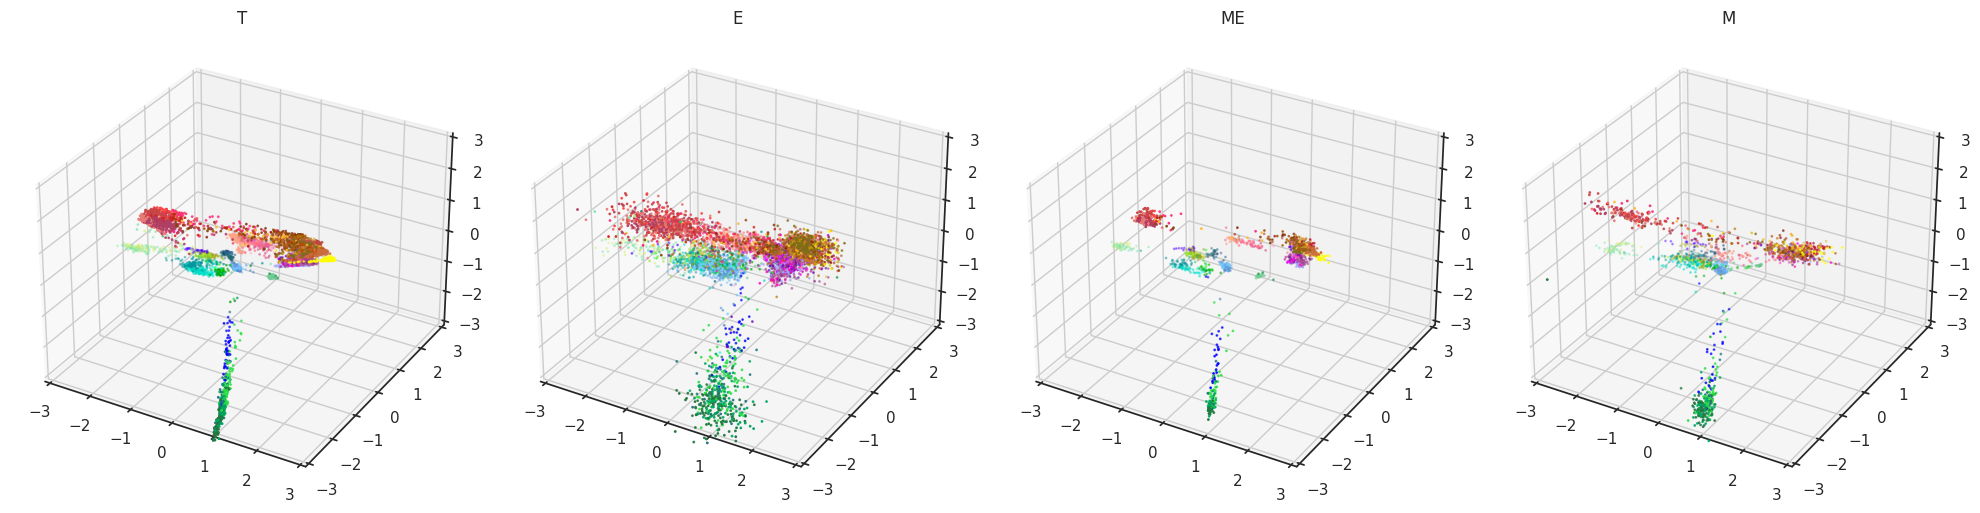

In [6]:
folder ="/home/fahimehb/Local/new_codes/cplAE_MET/data/results/optuna_all_connected_objective_comm_det_large_penalty_for_e_m_recon_v0/"
file= "Results_trial_431.pkl"
path = os.path.join(folder, file)
output = loadpkl(path)
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))

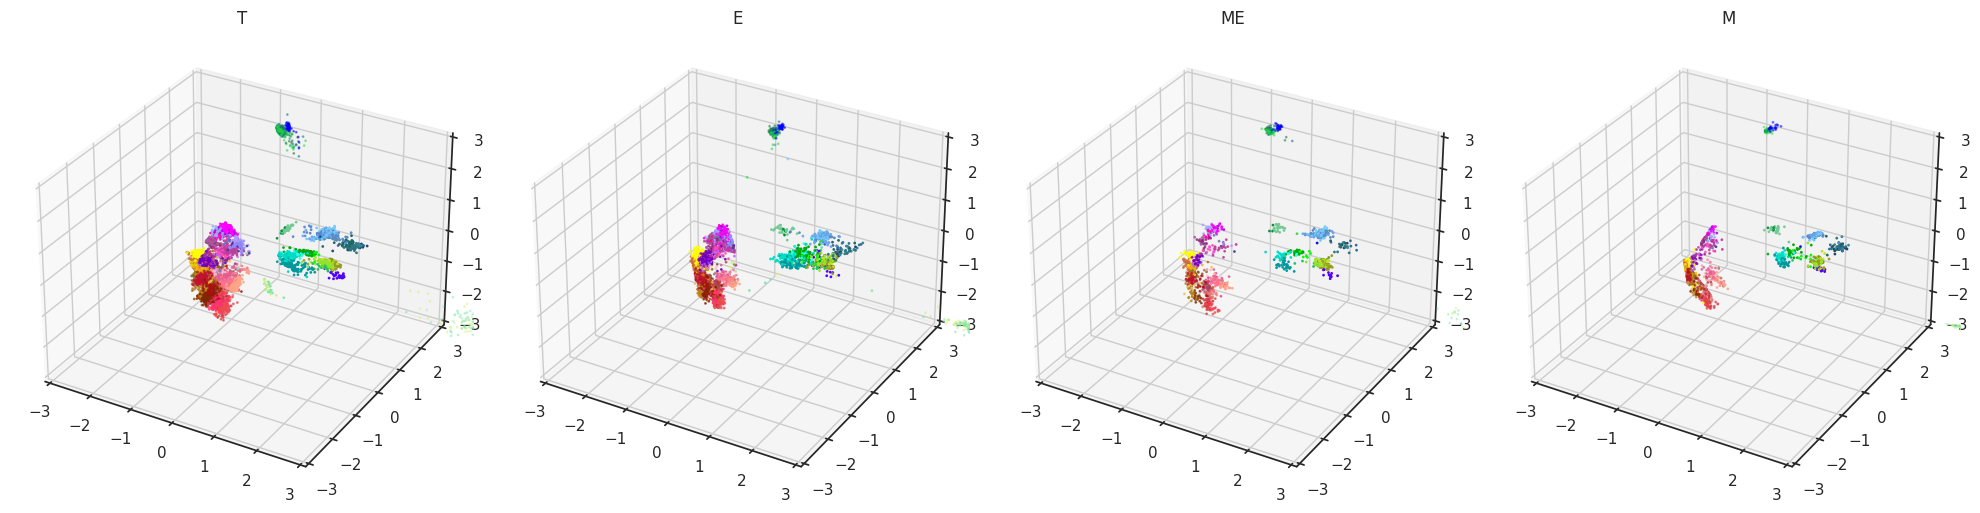

In [89]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/optuna_all_connected_objective_comm_det_10trial_2000epochs_1000runs"
file = f"exit_summary_fold_0_test.pkl"
dir = os.path.join(folder, file)
output = loadpkl(dir)
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))

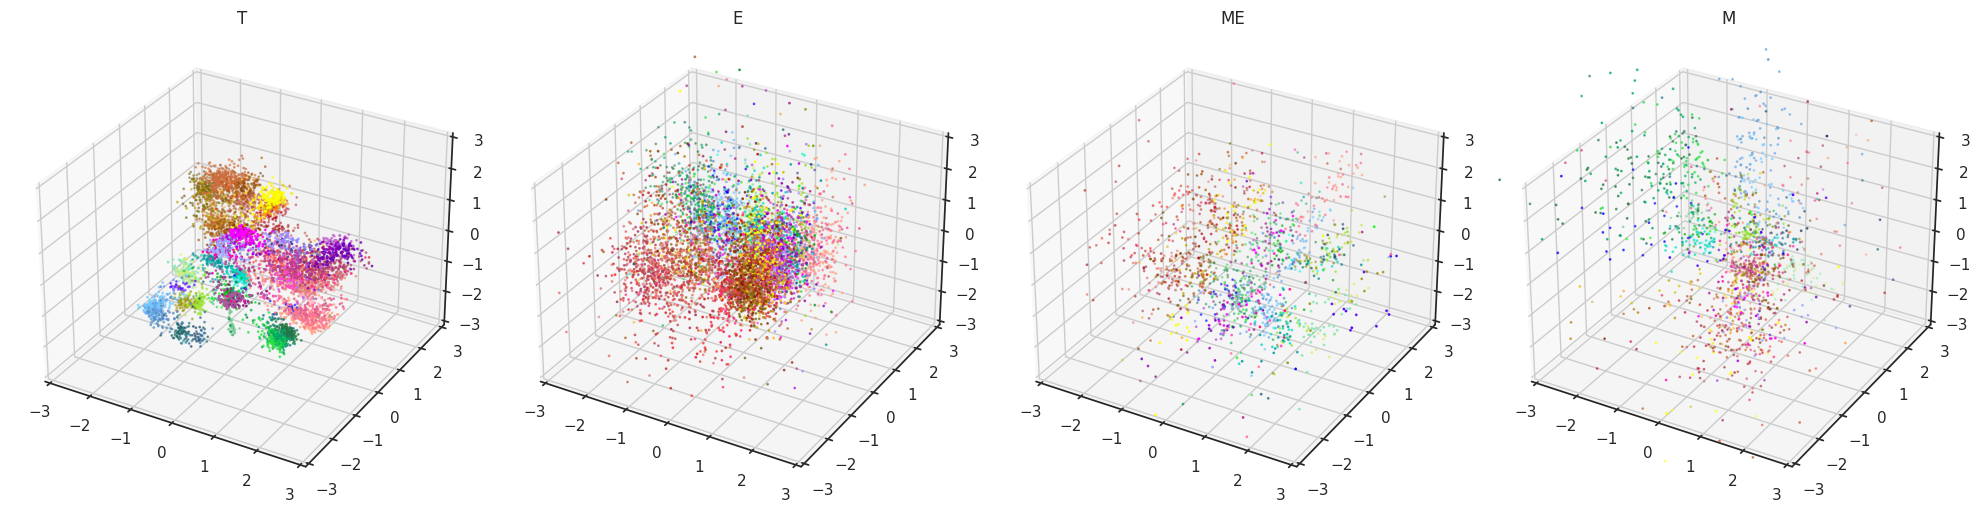

In [86]:
folder = "/home/fahimehb/Local/new_codes/cplAE_MET/data/results/Tonly-Eonly-Monly-autoencoders-14Feb2023"
file = f"exit_summary_fold_0_test.pkl"
dir = os.path.join(folder, file)
output = loadpkl(dir)
plot_z_3d(output, xlim=(-3,3), ylim=(-3, 3), zlim=(-3,3))

In [79]:
output.keys()

dict_keys(['XT', 'XM', 'XE', 'XrT', 'XrE', 'XrM', 'XrM_me_paired', 'XrE_me_paired', 'specimen_id', 'cluster_label', 'cluster_color', 'cluster_id', 'gene_ids', 'e_features', 'loss_rec_xt', 'loss_rec_xe', 'loss_rec_xm', 'loss_rec_xme_paired', 'loss_cpl_me->t', 'loss_cpl_t->me', 'loss_cpl_me->m', 'loss_cpl_m->me', 'loss_cpl_me->e', 'loss_cpl_e->me', 'loss_cpl_t->e', 'loss_cpl_e->t', 'loss_cpl_t->m', 'loss_cpl_m->t', 'loss_cpl_e->m', 'loss_cpl_m->e', 'zm', 'ze', 'zt', 'zme_paired', 'is_t_1d', 'is_e_1d', 'is_m_1d'])

In [7]:
X_train = m_input[val_ind]
# The ind of the cells that have no arbor densities but have other m features
to_drop = np.where(np.any(np.isnan(X_train.reshape(131,-1)), axis=1))[0]
val_ind = np.delete(val_ind, to_drop)
X_train = m_input[val_ind]

========================= Original data =============================


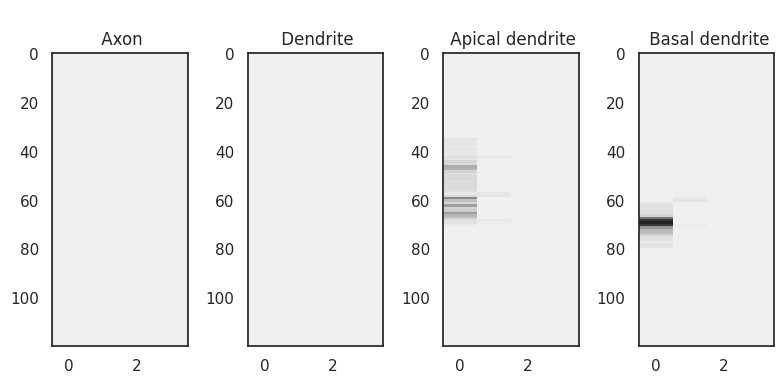

================= reconstructed data from PCs =====================


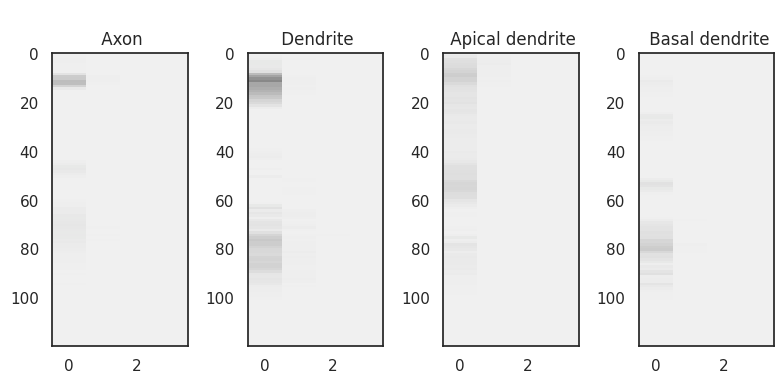

In [9]:
X_train_PC = output['XrM'][:,0:103][val_ind]
X_train = X_train.reshape(X_train.shape[0], 480, 4)
X_projected = np.zeros((X_train.shape[0], 480, 4))

n_comp_old = 0
for c, n_comp in zip(range(4), [12, 28, 40, 23]):
    pca = PCA(n_comp)
    _ = pca.fit_transform(X_train[...,c]) 
    X_projected[...,c] = pca.inverse_transform(X_train_PC[:, n_comp_old:n_comp_old+n_comp] * arbor_density_PC_vars[c])
    n_comp_old += n_comp

X_projected = X_projected.reshape(128, 120, 4, 4)
X_train = X_train.reshape(128, 120, 4, 4)

print("========================= Original data =============================")
plot_m(X_train[10,...])
print("================= reconstructed data from PCs =====================")
plot_m(X_projected[10,...])

========================= Original data =============================


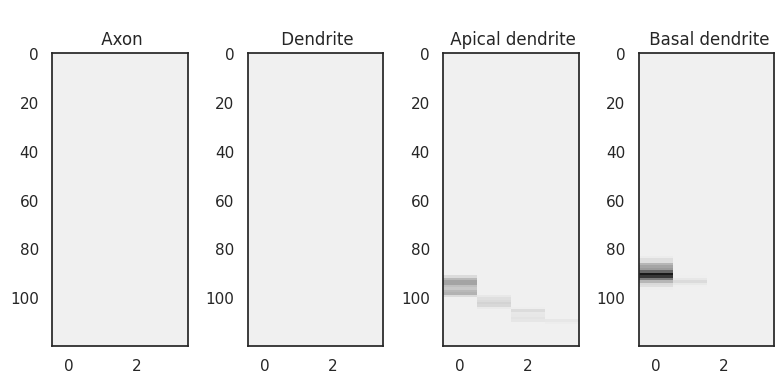

================= reconstructed data from PCs =====================


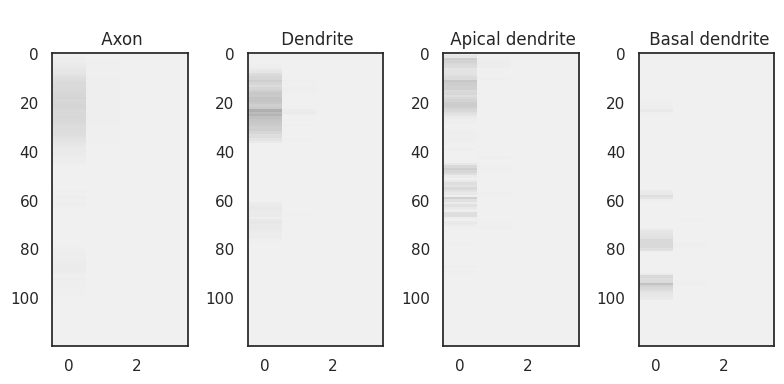

In [88]:
X_train_PC = output['XrM'][:,0:103][val_ind]
X_train = X_train.reshape(X_train.shape[0], 480, 4)
X_projected = np.zeros((X_train.shape[0], 480, 4))

n_comp_old = 0
for c, n_comp in zip(range(4), [12, 28, 40, 23]):
    pca = PCA(n_comp)
    _ = pca.fit_transform(X_train[...,c]) 
    X_projected[...,c] = pca.inverse_transform(X_train_PC[:, n_comp_old:n_comp_old+n_comp] * arbor_density_PC_vars[c])
    n_comp_old += n_comp

X_projected = X_projected.reshape(128, 120, 4, 4)
X_train = X_train.reshape(128, 120, 4, 4)

print("========================= Original data =============================")
plot_m(X_train[100,...])
print("================= reconstructed data from PCs =====================")
plot_m(X_projected[100,...])